In [ ]:
# Figure 3: GS/E Phase-Space Folds
# Reproduce Figure 3 from Belokurov et al. (2022) Energy Wrinkles paper.
# Shows chevron patterns in (v_r, r) space for GS/E debris.


In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.io import fits
from scipy.ndimage import gaussian_filter
import os

In [64]:
# Load Gaia 6D catalog
cat = Table.read(os.path.expanduser('~/data/gaia/gaia_dr3_6d_galactocentric.fits'))
print(f"Total stars: {len(cat):,}")

Total stars: 33,581,727


In [65]:
# Load Vasiliev+2021 GC catalog
vasiliev_file = os.path.expanduser('~/data/catalogues/gc_members_gaia_vasiliev.fits')

dgc = fits.getdata(vasiliev_file, 1)
gc_source_ids = dgc['SOURCE_ID'][dgc['prob'] > 0.0]

mask_gc = np.isin(cat['source_id'], gc_source_ids)
print(f"Removing {np.sum(mask_gc):,} GC members")

cat = cat[~mask_gc]


Removing 10,403 GC members


In [66]:
# Compute angular momentum L_z = X*VY - Y*VX
L_z = cat['X'] * cat['VY'] - cat['Y'] * cat['VX']

# Select GS/E: |L_z| < 0.7 × 10^3 kpc km/s
L_z_cut = 0.7e3
mask_gse = np.abs(L_z) < L_z_cut

# Split by L_z sign
mask_pro = (L_z > 0) & mask_gse      # Prograde
mask_ret = (L_z < 0) & mask_gse      # Retrograde

print(f"GS/E sample: {np.sum(mask_gse):,} stars")
print(f"  Prograde (L_z > 0): {np.sum(mask_pro):,}")
print(f"  Retrograde (L_z < 0): {np.sum(mask_ret):,}")

# Galactocentric spherical coordinates
r = np.sqrt(cat['X']**2 + cat['Y']**2 + cat['Z']**2)
v_r = (cat['X']*cat['VX'] + cat['Y']*cat['VY'] + cat['Z']*cat['VZ']) / r

GS/E sample: 2,953,981 stars
  Prograde (L_z > 0): 428,725
  Retrograde (L_z < 0): 2,525,256


In [216]:
# Cleaning and quality cuts
dist_sn_lim = 3.0  # Distance signal-to-noise limit
ebv_lim = 100.       # Reddening limit
dist_cut = 15.0    # kpc
par_sn_lim = 10.0    # Parallax signal-to-noise limit

# Distance cut: D_helio < 15 kpc
d_helio = cat['distance'] / 1000.0  # pc to kpc
mask_dist = d_helio < dist_cut

# Distance error cut: D / D_err > lim
mask_dist_err = (cat['distance'] / cat['distance_error']) > dist_sn_lim
mask_dist = mask_dist & mask_dist_err

# create a mask applying parallax S/N cut
parallax_sn = np.abs(cat['parallax'] / cat['parallax_error'])
mask_parallax = parallax_sn > par_sn_lim

# Reddening cut: ebv < ebv_lim
mask_ebv = cat['ebv'] < ebv_lim

# Final mask created but not applied
use = mask_dist & mask_ebv & mask_parallax

print(f"GS/E sample (after cuts): {np.sum(mask_gse & use):,} stars")
print(f"  Prograde (L_z > 0, after cuts): {np.sum(mask_pro & use):,}")
print(f"  Retrograde (L_z < 0, after cuts): {np.sum(mask_ret & use):,}")

GS/E sample (after cuts): 292,504 stars
  Prograde (L_z > 0, after cuts): 59,195
  Retrograde (L_z < 0, after cuts): 233,309


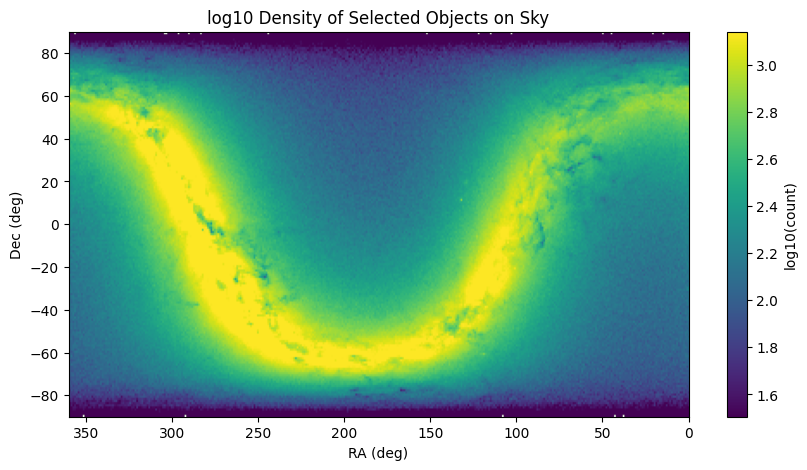

In [217]:
# Plot density of selected objects on the sky in (ra, dec)
ra = cat['ra'][use]
dec = cat['dec'][use]

# Define binning
n_ra, n_dec = 360, 180
ra_range = (0, 360)
dec_range = (-90, 90)

H_sky, xedges, yedges = np.histogram2d(ra, dec, bins=[n_ra, n_dec], range=[ra_range, dec_range])

# Take log10, mask zeros
H_sky_log = np.log10(H_sky.T, where=(H_sky.T > 0))
H_sky_log[H_sky.T == 0] = np.nan

plt.figure(figsize=(10, 5))
vmin = np.nanpercentile(H_sky_log, 5)
vmax = np.nanpercentile(H_sky_log, 95)
plt.imshow(H_sky_log, origin='lower', extent=[ra_range[0], ra_range[1], dec_range[0], dec_range[1]],
           aspect='auto', cmap='viridis', vmin=vmin, vmax=vmax)
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')
plt.title('log10 Density of Selected Objects on Sky')
plt.colorbar(label='log10(count)')
plt.gca().invert_xaxis()
plt.show()

In [224]:
# Create 2D historgram

# Axis ranges
r_range = (2.0, 14.0)   # kpc
vr_range = (-500, 500)  # km/s

# Top row, Bottom row: pixels
n_r_top, n_vr_top = 75, 150
n_r_bot, n_vr_bot = 50, 100

# FWHM in pixels (from paper)
fwhm = {'prograde': 9, 'retrograde': 15, 'combined': 12}
fwhm_smooth = 1.3  # Additional smoothing FWHM in pixels

# Three samples
samples = {
    'prograde': mask_pro,
    'retrograde': mask_ret,
    'combined': mask_gse
}

# Create histograms
H_top = {}
H_bot = {}

for name, mask in samples.items():
    #  Combine with use
    mask = mask & use

    # Top row
    H_top[name], _, _ = np.histogram2d(
        v_r[mask], r[mask],
        bins=[n_vr_top, n_r_top],
        range=[vr_range, r_range]
    )
    
    # Bottom row
    H_bot[name], _, _ = np.histogram2d(
        v_r[mask], r[mask],
        bins=[n_vr_bot, n_r_bot],
        range=[vr_range, r_range]
    )

# Column normalize: for each r bin, normalize by sum
def column_normalize(H):
    H_norm = H.copy()
    for i in range(H.shape[1]):
        col_sum = H[:, i].sum()
        if col_sum > 0:
            H_norm[:, i] /= col_sum
    return H_norm

# Top row: column normalize
H_top_norm = {name: column_normalize(H_top[name]) for name in samples}

# Bottom row: column normalize + subtract background
H_bot_norm = {name: column_normalize(H_bot[name]) for name in samples}

# Background subtraction via Gaussian smoothing

H_bot_sub = {}
for name in samples:
    # FWHM to sigma
    sigma = fwhm[name] / (2.0 * np.sqrt(2.0 * np.log(2.0)))
    
    # Smooth and subtract
    background = gaussian_filter(H_bot_norm[name], sigma=sigma, mode='constant')

    # Apply additional smoothing with FWHM = 1 pixel before background subtraction
    sigma_smooth = fwhm_smooth / (2.0 * np.sqrt(2.0 * np.log(2.0)))
    H_smoothed = gaussian_filter(H_bot_norm[name], sigma=sigma_smooth, mode='constant')

    H_bot_sub[name] = H_smoothed - background

/var/folders/jb/7f0bq_sx0435s1wvlt2yfkcr0000gn/T/ipykernel_5600/1429433643.py:13: RuntimeWarning: divide by zero encountered in log10
  H_plot = np.log10(H_top_norm[name])


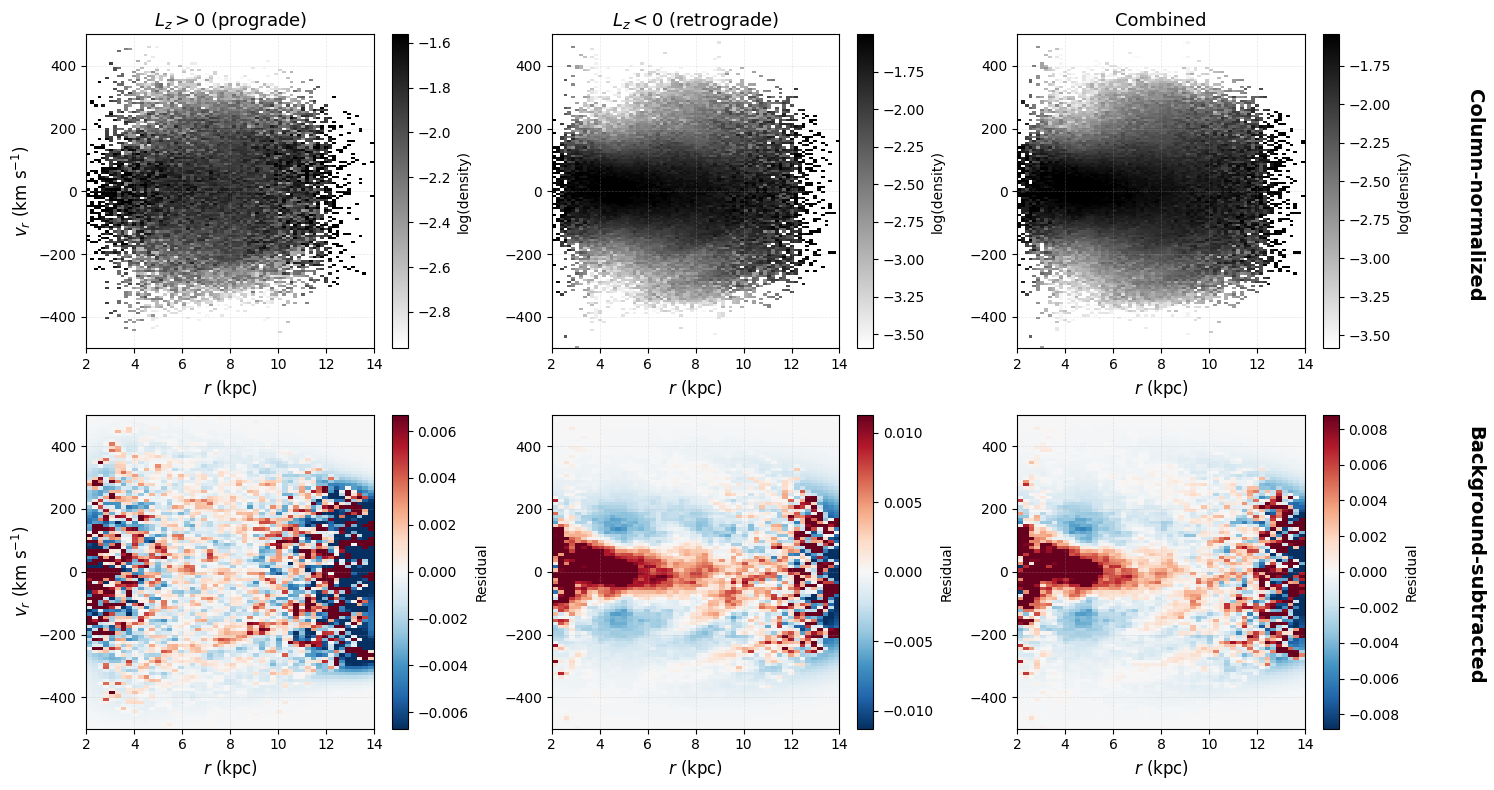

In [225]:
# Plotting

fig, axes = plt.subplots(2, 3, figsize=(15, 8))

titles = ['$L_z > 0$ (prograde)', '$L_z < 0$ (retrograde)', 'Combined']
extent_top = [r_range[0], r_range[1], vr_range[0], vr_range[1]]
extent_bot = extent_top

# Top row: column-normalized (log scale, grayscale)
for i, (name, title) in enumerate(zip(['prograde', 'retrograde', 'combined'], titles)):
    ax = axes[0, i]
    
    H_plot = np.log10(H_top_norm[name])
    
    # 5-95 percentile range
    finite_nonzero = H_plot[np.isfinite(H_plot) & (H_plot != 0)]
    vmin = np.percentile(finite_nonzero, 5)
    vmax = np.percentile(finite_nonzero, 95)
    
    im = ax.imshow(H_plot, origin='lower', extent=extent_top, aspect='auto',
                   cmap='gray_r', vmin=vmin, vmax=vmax, interpolation='nearest')
    
    ax.set_xlabel('$r$ (kpc)', fontsize=12)
    if i == 0:
        ax.set_ylabel('$v_r$ (km s$^{-1}$)', fontsize=12)
    ax.set_title(title, fontsize=13)
    ax.grid(alpha=0.3, linestyle='--', linewidth=0.5)
    
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('log(density)', fontsize=10)

# Bottom row: background-subtracted (RdBu_r)
for i, (name, title) in enumerate(zip(['prograde', 'retrograde', 'combined'], titles)):
    ax = axes[1, i]
    
    H_plot = H_bot_sub[name]
    
    # 5-95 percentile, symmetric
    vmin = np.percentile(H_plot, 5)
    vmax = np.percentile(H_plot, 95)
    vlim = max(abs(vmin), abs(vmax))
    
    im = ax.imshow(H_plot, origin='lower', extent=extent_bot, aspect='auto',
                   cmap='RdBu_r', vmin=-vlim, vmax=vlim, interpolation='nearest')
    
    ax.set_xlabel('$r$ (kpc)', fontsize=12)
    if i == 0:
        ax.set_ylabel('$v_r$ (km s$^{-1}$)', fontsize=12)
    ax.grid(alpha=0.3, linestyle='--', linewidth=0.5)
    
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Residual', fontsize=10)

# Row labels
fig.text(0.98, 0.75, 'Column-normalized', rotation=270, va='center', fontsize=14, weight='bold')
fig.text(0.98, 0.30, 'Background-subtracted', rotation=270, va='center', fontsize=14, weight='bold')

plt.tight_layout(rect=[0, 0, 0.96, 1])
plt.savefig('plots/figure3_phase_space_folds.png', dpi=200, bbox_inches='tight', facecolor='white')
plt.show()